## Comparing phyloP conservation of P-rich less/more dependent miRNAs

<p style="text-align: right;"> Written by Soomin Son
<p style="text-align: right;"> Last revised: 22. 05. 2021.</p>

### Purpose

- Compare phyloP conservation score of P-rich less/more dependent miRNAs 

In [1]:
import sys
sys.path.append('/casa/soomin/miniconda3/lib/python3.7/site-packages/')
sys.path.append('/casa/soomin/miniconda3/envs/py37/lib/python3.7/site-packages/')
sys.path.append('/casa/soomin/miniconda3/envs/py37/lib/python3.8/site-packages')

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#from matplotlib_venn import venn2

from scipy import stats
from scipy.stats import mannwhitneyu
from statannot import add_stat_annotation

import numpy as np
import pybedtools
import seaborn as sns
sns.set(style="ticks", palette="muted")

In [2]:
from matplotlib import font_manager

font_dirs = ['/casa/soomin/font/Helvetica/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

### Read pre-processed DEseq2 tables

- Get the list of pri-miRNAs from DD_filtered

In [3]:
DD_filtered = \
pd.read_csv("Results/200914_HCT116_DD_filtered.csv")[['mature', 'baseMean', 'log2FoldChange', 'padj', 'pri-miRNA', \
                                                      'curated DROSHA dependency (HCT116)']].set_index("mature")

In [4]:
DD_filtered.head()

,baseMean,log2FoldChange,padj,pri-miRNA,curated DROSHA dependency (HCT116)
mature,,,,,
hsa-let-7a-2-3p,52.394713,-0.901333,0.066836,hsa-let-7a-2,DROSHA-dependent
hsa-let-7a-3p,410.786354,-0.089378,0.740194,NaN,DROSHA-dependent
hsa-let-7a-5p,15216.651736,0.009163,0.982280,NaN,DROSHA-dependent
hsa-let-7b-3p,113.500150,-0.583679,0.076425,hsa-let-7b,DROSHA-dependent
hsa-let-7b-5p,3288.216511,-0.136267,0.691858,hsa-let-7b,DROSHA-dependent


In [5]:
my_pri = set(DD_filtered["pri-miRNA"].dropna())
len(my_pri)

190

### Make phyloP table for pri-miRNAs

- In order to retrieve phyloP score for pri-miRNAs from UCSC genome browser, prepare the chr, start, end of each pri 

In [6]:
pri_genome_coordinate = \
pd.read_table("200326_curated_hg38_mature_miRNA_classification.txt")[['pri miRNA', 'Chr', 'pri Start', 'pri End']].set_index('pri miRNA').drop_duplicates()

print(pri_genome_coordinate.shape)
pri_genome_coordinate.head()

(1870, 3)


,Chr,pri Start,pri End
pri miRNA,,,
hsa-mir-6859-1,chr1,17369,17436
hsa-mir-1302-2,chr1,30366,30503
hsa-mir-6859-2,chr1,187891,187958
hsa-mir-6723,chr1,632325,632413
hsa-mir-200b,chr1,1167104,1167198


In [7]:
pri_genome_coordinate = pri_genome_coordinate.loc[my_pri]
print(pri_genome_coordinate.shape)

(190, 3)


Make some mofidications

- The current table is 1-based and inclusive ([]) 
- Change it to bed format

In [8]:
pri_genome_coordinate["pri Start"] = pri_genome_coordinate["pri Start"] - 1 

In [9]:
pri_genome_coordinate.head()

,Chr,pri Start,pri End
pri miRNA,,,
hsa-mir-1247,chr14,101560286,101560422
hsa-mir-182,chr7,129770382,129770492
hsa-mir-576,chr4,109488697,109488795
hsa-mir-449c,chr5,55172261,55172353
hsa-mir-361,chrX,85903635,85903707


Make bed file for UCSC genome browser input

In [10]:
pri_genome_coordinate.reset_index()[["Chr", "pri Start", 'pri End']].to_csv('210522_pri_phyloP_input.tsv', sep='\t', header=None, index=False)

Read output file from UCSC output(210522_pri_phyloP100_output(wig file format) -> 210522_pri_phyloP100_output(bed file format))

In [11]:
pri_phyloP = pd.read_table("210522_pri_phyloP100_output.bed", header=None).iloc[:,[0,1,4]]
pri_phyloP.rename(columns={0: "Chr", 1:"Coordinate", 4:"phyloP100"}, inplace=True)
pri_phyloP.head()

,Chr,Coordinate,phyloP100
0,chr1,1167862,-0.106118
1,chr1,1167863,-0.603283
2,chr1,1167864,1.981980
3,chr1,1167865,3.572910
4,chr1,1167866,0.291614


In [12]:
pri_genome_coordinate["phyloP_avg"] = 0

pri_Start = pri_genome_coordinate.loc["hsa-mir-29b-2", 'pri Start']
pri_End = pri_genome_coordinate.loc["hsa-mir-29b-2", 'pri End']
pri_len = pri_End - pri_Start

pri_chr = pri_genome_coordinate.loc['hsa-mir-29b-2', 'Chr']

phyloP_sum = 0
for i in range(pri_Start, pri_End):
    score = float(pri_phyloP[(pri_phyloP["Chr"] == pri_chr) & (pri_phyloP["Coordinate"] == i)]['phyloP100'])
    print(score)

6.44846
2.94131
5.09085
6.56159
3.95951
5.99592
6.10906
5.99592
7.80606
6.56159
7.80606
6.56159
2.82817
8.37173
7.80606
6.67472
6.67472
6.67472
6.56159
7.80606
7.80606
7.80606
6.67472
8.37173
8.37173
6.67472
8.37173
6.56159
6.67472
7.80606
8.37173
7.80606
3.95951
2.03624
2.71504
4.63831
1.69683
3.50698
4.97772
5.65652
3.95951
3.16757
2.71504
2.37564
3.84638
2.2625
5.88279
5.65652
6.67472
6.56159
6.56159
7.69293
7.69293
4.29891
2.82817
6.56159
7.69293
6.56159
6.56159
7.69293
2.14937
3.28071
4.75145
8.2586
7.69293
7.69293
7.69293
6.56159
6.56159
5.99592
8.2586
3.50698
6.56159
3.62011
6.56159
3.73324
4.52518
6.44846
5.65652
2.2625
5.20398


In [13]:
pri_genome_coordinate["phyloP_avg"] = 0 

# hsa-mir-203a, hsa-mir-203b are strange, Need to check
for pri in pri_genome_coordinate.index:
    pri_Start = pri_genome_coordinate.loc[pri, 'pri Start']
    pri_End = pri_genome_coordinate.loc[pri, 'pri End']
    pri_len = pri_End - pri_Start
    
    pri_chr = pri_genome_coordinate.loc[pri, 'Chr']
    
    phyloP_sum = 0
    
    for i in range(pri_Start, pri_End):
        score = pri_phyloP[(pri_phyloP["Chr"] == pri_chr) & (pri_phyloP["Coordinate"] == i)]['phyloP100'].values
        phyloP_sum  = phyloP_sum + score
    phyloP_sum = np.mean(phyloP_sum)
    pri_genome_coordinate.loc[pri, "phyloP_avg"] = phyloP_sum/pri_len 

In [14]:
pri_genome_coordinate.head()

,Chr,pri Start,pri End,phyloP_avg
pri miRNA,,,,
hsa-mir-1247,chr14,101560286,101560422,0.563673
hsa-mir-182,chr7,129770382,129770492,4.626365
hsa-mir-576,chr4,109488697,109488795,-0.338939
hsa-mir-449c,chr5,55172261,55172353,1.556630
hsa-mir-361,chrX,85903635,85903707,2.379111


### Define P-rich more/less dependent

- log2 FC cutoff = 1.53452924346508
- p-value cutoff = 0.05

In [15]:
log2FC_cutoff = 1.53452924346508

In [16]:
DD_filtered.loc[DD_filtered[(DD_filtered["padj"] < 0.05) & (DD_filtered["log2FoldChange"].abs() > log2FC_cutoff)].index, 'P-rich dep'] = "More dependent"
DD_filtered.loc[DD_filtered[(DD_filtered["padj"] >= 0.05) | (DD_filtered["log2FoldChange"].abs() <= log2FC_cutoff)].index, 'P-rich dep'] = "Less dependent"

In [17]:
DD_filtered["P-rich dep"].value_counts()

Less dependent    241
More dependent     67
Name: P-rich dep, dtype: int64

In [18]:
DD_filtered.head()

,baseMean,log2FoldChange,padj,pri-miRNA,curated DROSHA dependency (HCT116),P-rich dep
mature,,,,,,
hsa-let-7a-2-3p,52.394713,-0.901333,0.066836,hsa-let-7a-2,DROSHA-dependent,Less dependent
hsa-let-7a-3p,410.786354,-0.089378,0.740194,NaN,DROSHA-dependent,Less dependent
hsa-let-7a-5p,15216.651736,0.009163,0.982280,NaN,DROSHA-dependent,Less dependent
hsa-let-7b-3p,113.500150,-0.583679,0.076425,hsa-let-7b,DROSHA-dependent,Less dependent
hsa-let-7b-5p,3288.216511,-0.136267,0.691858,hsa-let-7b,DROSHA-dependent,Less dependent


In [19]:
pri_phyloP_joined = DD_filtered.join(pri_genome_coordinate, on='pri-miRNA')
pri_phyloP_joined.head()
#mannwhitneyu(tmp[tmp["P-rich dep"] == "Less dependent"]['phyloP_avg'], tmp[tmp["P-rich dep"] == "More dependent"]['phyloP_avg'], alternative = 'two-sided')
#tmp[tmp["P-rich dep"] == "Less dependent"]['phyloP_avg']
#tmp[tmp["P-rich dep"] == "More dependent"]['phyloP_avg']

,baseMean,log2FoldChange,padj,pri-miRNA,curated DROSHA dependency (HCT116),P-rich dep,Chr,pri Start,pri End,phyloP_avg
mature,,,,,,,,,,
hsa-let-7a-2-3p,52.394713,-0.901333,0.066836,hsa-let-7a-2,DROSHA-dependent,Less dependent,chr11,122146521.0,122146593.0,6.635873
hsa-let-7a-3p,410.786354,-0.089378,0.740194,NaN,DROSHA-dependent,Less dependent,NaN,NaN,NaN,NaN
hsa-let-7a-5p,15216.651736,0.009163,0.982280,NaN,DROSHA-dependent,Less dependent,NaN,NaN,NaN,NaN
hsa-let-7b-3p,113.500150,-0.583679,0.076425,hsa-let-7b,DROSHA-dependent,Less dependent,chr22,46113685.0,46113768.0,5.978929
hsa-let-7b-5p,3288.216511,-0.136267,0.691858,hsa-let-7b,DROSHA-dependent,Less dependent,chr22,46113685.0,46113768.0,5.978929


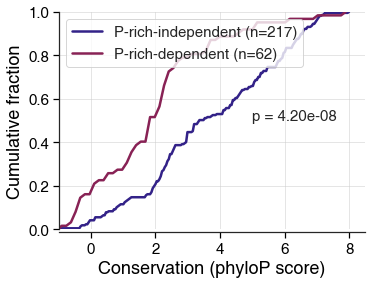

In [20]:
fig, ax = plt.subplots(1,1,figsize=(5.5, 4))

less_dep = pri_phyloP_joined[pri_phyloP_joined["P-rich dep"] == "Less dependent"]['phyloP_avg'].dropna()
more_dep = pri_phyloP_joined[pri_phyloP_joined["P-rich dep"] == "More dependent"]['phyloP_avg'].dropna()

### evaluate the histogram
less_dep_values, less_dep_base = np.histogram(less_dep, bins = len(less_dep))
more_dep_values, more_dep_base = np.histogram(more_dep, bins = len(more_dep))

### evaluate cumulative
less_dep_cumulative = np.cumsum(less_dep_values) / np.sum(less_dep_values)
more_dep_cumulative = np.cumsum(more_dep_values) / np.sum(more_dep_values)

ax.plot(np.insert(less_dep_base[:-1], 0, less_dep_base[0]-0.1, axis = 0), \
        np.insert(less_dep_cumulative,0,0, axis=0), label='P-rich-independent '+'(n='+str(len(less_dep))+")", \
        color = '#332288', linewidth=2.5)
ax.plot(np.insert(more_dep_base[:-1],0,more_dep_base[0]-0.1, axis=0),\
       np.insert(more_dep_cumulative,0,0,axis=0), label="P-rich-dependent " + "(n=" +str(len(more_dep))+")",\
       color='#882255', linewidth=2.5)

ax.set_xlim(-1,8.5)
ax.set_ylim(0,1)
ax.set_xlabel("Conservation (phyloP score)", fontsize=18, color='black')
ax.set_ylabel("Cumulative fraction", fontsize=18, color='black')
ax.set_title("")
ax.legend(loc="upper left", fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
    
p0 = mannwhitneyu(less_dep, more_dep, alternative = 'two-sided')[1]
ax.text(5,0.5, 'p = %.2e'%p0, fontsize=15)
fig.show()

#plt.savefig("Results/Figures/210522-phyloP-HCT116.pdf", bbox_inches='tight')
del less_dep, more_dep, less_dep_values, less_dep_base, more_dep_values, more_dep_base, less_dep_cumulative, more_dep_cumulative

### Cumulative plot comparing intronic v.s. exonic (교수님 요청)

In [21]:
DD_analysis = pd.read_csv("210308_HCT116_DD_analysis.csv")[['mature', 'baseMean', 'log2FoldChange', 'padj', 'pri-miRNA', 'Exon_Intron']].set_index("mature")

In [22]:
log2FC_cutoff = 1.53452924346508

DD_analysis.loc[DD_analysis[(DD_analysis["padj"] < 0.05) & (DD_analysis["log2FoldChange"].abs() > log2FC_cutoff)].index, 'P-rich dep'] = "More dependent"
DD_analysis.loc[DD_analysis[(DD_analysis["padj"] >= 0.05) | (DD_analysis["log2FoldChange"].abs() <= log2FC_cutoff)].index, 'P-rich dep'] = "Less dependent"

DD_analysis.head()


,baseMean,log2FoldChange,padj,pri-miRNA,Exon_Intron,P-rich dep
mature,,,,,,
hsa-let-7a-2-3p,52.394713,-0.901333,6.683580e-02,hsa-let-7a-2,intronic,Less dependent
hsa-let-7b-3p,113.500150,-0.583679,7.642490e-02,hsa-let-7b,exonic,Less dependent
hsa-let-7b-5p,3288.216511,-0.136267,6.918580e-01,hsa-let-7b,exonic,Less dependent
hsa-let-7c-5p,86.709270,-0.235136,5.822707e-01,hsa-let-7c,intronic,Less dependent
hsa-let-7d-3p,205.664358,-2.068898,4.782894e-14,hsa-let-7d,intronic,More dependent


In [23]:
my_pri = set(DD_analysis["pri-miRNA"].dropna())
len(my_pri)

190

In [135]:
pri_genome_coordinate = \
pd.read_table("200326_curated_hg38_mature_miRNA_classification.txt")[['pri miRNA', 'Chr', 'pri Start', 'pri End']].set_index('pri miRNA').drop_duplicates()

print(pri_genome_coordinate.shape)
pri_genome_coordinate.head()

(1870, 3)


,Chr,pri Start,pri End
pri miRNA,,,
hsa-mir-6859-1,chr1,17369,17436
hsa-mir-1302-2,chr1,30366,30503
hsa-mir-6859-2,chr1,187891,187958
hsa-mir-6723,chr1,632325,632413
hsa-mir-200b,chr1,1167104,1167198


In [136]:
pri_genome_coordinate = pri_genome_coordinate.loc[my_pri]
print(pri_genome_coordinate.shape)

(190, 3)


In [137]:
pri_genome_coordinate["pri Start"] = pri_genome_coordinate["pri Start"] - 1 
pri_genome_coordinate.head()

,Chr,pri Start,pri End
pri miRNA,,,
hsa-mir-1247,chr14,101560286,101560422
hsa-mir-182,chr7,129770382,129770492
hsa-mir-576,chr4,109488697,109488795
hsa-mir-449c,chr5,55172261,55172353
hsa-mir-361,chrX,85903635,85903707


In [27]:
pri_genome_coordinate.reset_index()[["Chr", "pri Start", 'pri End']].to_csv('210522_pri_phyloP_input.tsv', sep='\t', header=None, index=False)

In [28]:
pri_phyloP = pd.read_table("210522_pri_phyloP100_output.bed", header=None).iloc[:,[0,1,4]]
pri_phyloP.rename(columns={0: "Chr", 1:"Coordinate", 4:"phyloP100"}, inplace=True)
pri_phyloP.head()

,Chr,Coordinate,phyloP100
0,chr1,1167862,-0.106118
1,chr1,1167863,-0.603283
2,chr1,1167864,1.981980
3,chr1,1167865,3.572910
4,chr1,1167866,0.291614


In [29]:
pri_genome_coordinate["phyloP_avg"] = 0

pri_Start = pri_genome_coordinate.loc["hsa-mir-29b-2", 'pri Start']
pri_End = pri_genome_coordinate.loc["hsa-mir-29b-2", 'pri End']
pri_len = pri_End - pri_Start

pri_chr = pri_genome_coordinate.loc['hsa-mir-29b-2', 'Chr']

phyloP_sum = 0
for i in range(pri_Start, pri_End):
    score = float(pri_phyloP[(pri_phyloP["Chr"] == pri_chr) & (pri_phyloP["Coordinate"] == i)]['phyloP100'])
    print(score)

6.44846
2.94131
5.09085
6.56159
3.95951
5.99592
6.10906
5.99592
7.80606
6.56159
7.80606
6.56159
2.82817
8.37173
7.80606
6.67472
6.67472
6.67472
6.56159
7.80606
7.80606
7.80606
6.67472
8.37173
8.37173
6.67472
8.37173
6.56159
6.67472
7.80606
8.37173
7.80606
3.95951
2.03624
2.71504
4.63831
1.69683
3.50698
4.97772
5.65652
3.95951
3.16757
2.71504
2.37564
3.84638
2.2625
5.88279
5.65652
6.67472
6.56159
6.56159
7.69293
7.69293
4.29891
2.82817
6.56159
7.69293
6.56159
6.56159
7.69293
2.14937
3.28071
4.75145
8.2586
7.69293
7.69293
7.69293
6.56159
6.56159
5.99592
8.2586
3.50698
6.56159
3.62011
6.56159
3.73324
4.52518
6.44846
5.65652
2.2625
5.20398


In [30]:
pri_genome_coordinate["phyloP_avg"] = 0 

# hsa-mir-203a, hsa-mir-203b are strange, Need to check
for pri in pri_genome_coordinate.index:
    pri_Start = pri_genome_coordinate.loc[pri, 'pri Start']
    pri_End = pri_genome_coordinate.loc[pri, 'pri End']
    pri_len = pri_End - pri_Start
    
    pri_chr = pri_genome_coordinate.loc[pri, 'Chr']
    
    phyloP_sum = 0
    
    for i in range(pri_Start, pri_End):
        score = pri_phyloP[(pri_phyloP["Chr"] == pri_chr) & (pri_phyloP["Coordinate"] == i)]['phyloP100'].values
        phyloP_sum  = phyloP_sum + score
    phyloP_sum = np.mean(phyloP_sum)
    pri_genome_coordinate.loc[pri, "phyloP_avg"] = phyloP_sum/pri_len 

In [32]:
pri_genome_coordinate.head()

,Chr,pri Start,pri End,phyloP_avg
pri miRNA,,,,
hsa-mir-1247,chr14,101560286,101560422,0.563673
hsa-mir-182,chr7,129770382,129770492,4.626365
hsa-mir-576,chr4,109488697,109488795,-0.338939
hsa-mir-449c,chr5,55172261,55172353,1.556630
hsa-mir-361,chrX,85903635,85903707,2.379111


In [33]:
pri_phyloP_joined = DD_analysis.join(pri_genome_coordinate, on='pri-miRNA')
pri_phyloP_joined.head()

,baseMean,log2FoldChange,padj,pri-miRNA,Exon_Intron,P-rich dep,Chr,pri Start,pri End,phyloP_avg
mature,,,,,,,,,,
hsa-let-7a-2-3p,52.394713,-0.901333,6.683580e-02,hsa-let-7a-2,intronic,Less dependent,chr11,122146521,122146593,6.635873
hsa-let-7b-3p,113.500150,-0.583679,7.642490e-02,hsa-let-7b,exonic,Less dependent,chr22,46113685,46113768,5.978929
hsa-let-7b-5p,3288.216511,-0.136267,6.918580e-01,hsa-let-7b,exonic,Less dependent,chr22,46113685,46113768,5.978929
hsa-let-7c-5p,86.709270,-0.235136,5.822707e-01,hsa-let-7c,intronic,Less dependent,chr21,16539827,16539911,7.165179
hsa-let-7d-3p,205.664358,-2.068898,4.782894e-14,hsa-let-7d,intronic,More dependent,chr9,94178833,94178920,5.244117


In [35]:
tmp = pri_phyloP_joined[pri_phyloP_joined["Exon_Intron"] == 'intronic']
tmp2 = pri_phyloP_joined[pri_phyloP_joined["Exon_Intron"] == 'exonic']

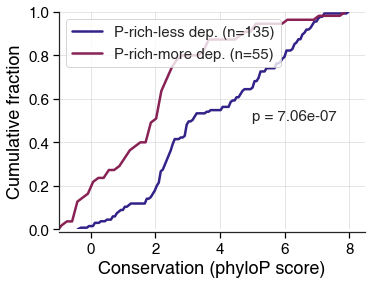

In [32]:
fig, ax = plt.subplots(1,1,figsize=(5.5, 4))

less_dep = tmp[tmp["P-rich dep"] == "Less dependent"]['phyloP_avg'].dropna()
more_dep = tmp[tmp["P-rich dep"] == "More dependent"]['phyloP_avg'].dropna()

### evaluate the histogram
less_dep_values, less_dep_base = np.histogram(less_dep, bins = len(less_dep))
more_dep_values, more_dep_base = np.histogram(more_dep, bins = len(more_dep))

### evaluate cumulative
less_dep_cumulative = np.cumsum(less_dep_values) / np.sum(less_dep_values)
more_dep_cumulative = np.cumsum(more_dep_values) / np.sum(more_dep_values)

ax.plot(np.insert(less_dep_base[:-1], 0, less_dep_base[0]-0.1, axis = 0), \
        np.insert(less_dep_cumulative,0,0, axis=0), label='P-rich-less dep. '+'(n='+str(len(less_dep))+")", \
        color = '#332288', linewidth=2.5)
ax.plot(np.insert(more_dep_base[:-1],0,more_dep_base[0]-0.1, axis=0),\
       np.insert(more_dep_cumulative,0,0,axis=0), label="P-rich-more dep. " + "(n=" +str(len(more_dep))+")",\
       color='#882255', linewidth=2.5)

ax.set_xlim(-1,8.5)
ax.set_ylim(0,1)
ax.set_xlabel("Conservation (phyloP score)", fontsize=18, color='black')
ax.set_ylabel("Cumulative fraction", fontsize=18, color='black')
ax.set_title("")
ax.legend(loc="upper left", fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
    
p0 = mannwhitneyu(less_dep, more_dep, alternative = 'two-sided')[1]
ax.text(5,0.5, 'p = %.2e'%p0, fontsize=15)
fig.show()

#plt.savefig("Results/Figures/210522-phyloP-HCT116.pdf", bbox_inches='tight')
del less_dep, more_dep, less_dep_values, less_dep_base, more_dep_values, more_dep_base, less_dep_cumulative, more_dep_cumulative

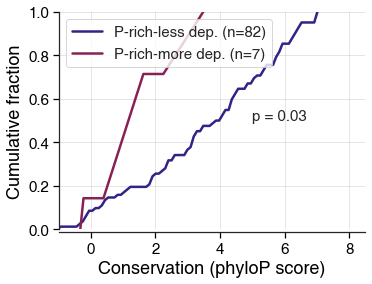

In [37]:
fig, ax = plt.subplots(1,1,figsize=(5.5, 4))

less_dep = tmp2[tmp2["P-rich dep"] == "Less dependent"]['phyloP_avg'].dropna()
more_dep = tmp2[tmp2["P-rich dep"] == "More dependent"]['phyloP_avg'].dropna()

### evaluate the histogram
less_dep_values, less_dep_base = np.histogram(less_dep, bins = len(less_dep))
more_dep_values, more_dep_base = np.histogram(more_dep, bins = len(more_dep))

### evaluate cumulative
less_dep_cumulative = np.cumsum(less_dep_values) / np.sum(less_dep_values)
more_dep_cumulative = np.cumsum(more_dep_values) / np.sum(more_dep_values)

ax.plot(np.insert(less_dep_base[:-1], 0, less_dep_base[0]-0.1, axis = 0), \
        np.insert(less_dep_cumulative,0,0, axis=0), label='P-rich-less dep. '+'(n='+str(len(less_dep))+")", \
        color = '#332288', linewidth=2.5)
ax.plot(np.insert(more_dep_base[:-1],0,more_dep_base[0]-0.1, axis=0),\
       np.insert(more_dep_cumulative,0,0,axis=0), label="P-rich-more dep. " + "(n=" +str(len(more_dep))+")",\
       color='#882255', linewidth=2.5)

ax.set_xlim(-1,8.5)
ax.set_ylim(0,1)
ax.set_xlabel("Conservation (phyloP score)", fontsize=18, color='black')
ax.set_ylabel("Cumulative fraction", fontsize=18, color='black')
ax.set_title("")
ax.legend(loc="upper left", fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
    
p0 = mannwhitneyu(less_dep, more_dep, alternative = 'two-sided')[1]
ax.text(5,0.5, 'p = %.2f'%p0, fontsize=15)
fig.show()

#plt.savefig("Results/Figures/210522-phyloP-HCT116.pdf", bbox_inches='tight')
del less_dep, more_dep, less_dep_values, less_dep_base, more_dep_values, more_dep_base, less_dep_cumulative, more_dep_cumulative

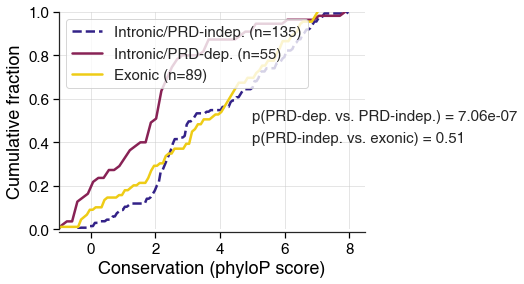

In [57]:
fig, ax = plt.subplots(1,1,figsize=(5.5, 4))


less_dep_intronic = \
pri_phyloP_joined[(pri_phyloP_joined["Exon_Intron"] == 'intronic') & (pri_phyloP_joined["P-rich dep"] == "Less dependent")]['phyloP_avg'].dropna()
more_dep_intronic = \
pri_phyloP_joined[(pri_phyloP_joined["Exon_Intron"] == 'intronic') & (pri_phyloP_joined["P-rich dep"] == "More dependent")]['phyloP_avg'].dropna()
exonic = pri_phyloP_joined[pri_phyloP_joined["Exon_Intron"] == 'exonic']['phyloP_avg'].dropna()


### evaluate the histogram
less_dep_intronic_values, less_dep_intronic_base = np.histogram(less_dep_intronic, bins = len(less_dep_intronic))
more_dep_intronic_values, more_dep_intronic_base = np.histogram(more_dep_intronic, bins = len(more_dep_intronic))
exonic_values, exonic_base = np.histogram(exonic, bins = len(exonic))

### evaluate cumulative
less_dep_intronic_cumulative = np.cumsum(less_dep_intronic_values) / np.sum(less_dep_intronic_values)
more_dep_intronic_cumulative = np.cumsum(more_dep_intronic_values) / np.sum(more_dep_intronic_values)
exonic_cumulative = np.cumsum(exonic_values) / np.sum(exonic_values)

ax.plot(np.insert(less_dep_intronic_base[:-1], 0, less_dep_intronic_base[0]-0.1, axis = 0), \
        np.insert(less_dep_intronic_cumulative,0,0, axis=0), label='Intronic/PRD-indep. '+'(n='+str(len(less_dep_intronic))+")", \
        color = '#332288', linewidth=2.5, linestyle = '--')
ax.plot(np.insert(more_dep_intronic_base[:-1],0,more_dep_intronic_base[0]-0.1, axis=0),\
       np.insert(more_dep_intronic_cumulative,0,0,axis=0), label="Intronic/PRD-dep. " + "(n=" +str(len(more_dep_intronic))+")",\
       color='#882255', linewidth=2.5)
ax.plot(np.insert(exonic_base[:-1],0,exonic_base[0]-0.1, axis=0),\
       np.insert(exonic_cumulative,0,0,axis=0), label="Exonic " + "(n=" +str(len(exonic))+")",\
       color='#eecc16', linewidth=2.5)

ax.set_xlim(-1,8.5)
ax.set_ylim(0,1)
ax.set_xlabel("Conservation (phyloP score)", fontsize=18, color='black')
ax.set_ylabel("Cumulative fraction", fontsize=18, color='black')
ax.set_title("")
ax.legend(loc="upper left", fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
    
p0 = mannwhitneyu(less_dep_intronic, more_dep_intronic, alternative = 'two-sided')[1]
ax.text(5,0.5, 'p(PRD-dep. vs. PRD-indep.) = %.2e'%p0, fontsize=15)
p1 = mannwhitneyu(less_dep_intronic, exonic, alternative = 'two-sided')[1]
ax.text(5,0.4, 'p(PRD-indep. vs. exonic) = %.2f'%p1, fontsize=15)


fig.show()

#plt.savefig("Results/Figures/221024-phyloP-HCT116.svg", bbox_inches='tight')

### 221102 Comparing processing efficiency/homogeneity between above groups

In [60]:
only_MP = pd.read_excel('from_KJ_SC/220308_KJ_paper_MP_only.xlsx', engine = 'openpyxl')[["Pri-miRNA", "Cleavage Efficiency", "Cleavage Homogeneity"]].set_index("Pri-miRNA")
only_MP.head()

,Cleavage Efficiency,Cleavage Homogeneity
Pri-miRNA,,
hsa-let-7a-1,4.051311,0.882549
hsa-let-7a-2,3.272476,0.787974
hsa-let-7a-3,1.761117,0.499679
hsa-let-7b,3.022173,0.767644
hsa-let-7c,0.000000,0.119761


In [61]:
pri_phyloP_joined.head()

,baseMean,log2FoldChange,padj,pri-miRNA,Exon_Intron,P-rich dep,Chr,pri Start,pri End,phyloP_avg
mature,,,,,,,,,,
hsa-let-7a-2-3p,52.394713,-0.901333,6.683580e-02,hsa-let-7a-2,intronic,Less dependent,chr11,122146521,122146593,6.635873
hsa-let-7b-3p,113.500150,-0.583679,7.642490e-02,hsa-let-7b,exonic,Less dependent,chr22,46113685,46113768,5.978929
hsa-let-7b-5p,3288.216511,-0.136267,6.918580e-01,hsa-let-7b,exonic,Less dependent,chr22,46113685,46113768,5.978929
hsa-let-7c-5p,86.709270,-0.235136,5.822707e-01,hsa-let-7c,intronic,Less dependent,chr21,16539827,16539911,7.165179
hsa-let-7d-3p,205.664358,-2.068898,4.782894e-14,hsa-let-7d,intronic,More dependent,chr9,94178833,94178920,5.244117


In [66]:
KJ_joined = pri_phyloP_joined.join(only_MP, on='pri-miRNA', how='left')
KJ_joined.head()

,baseMean,log2FoldChange,padj,pri-miRNA,Exon_Intron,P-rich dep,Chr,pri Start,pri End,phyloP_avg,Cleavage Efficiency,Cleavage Homogeneity
mature,,,,,,,,,,,,
hsa-let-7a-2-3p,52.394713,-0.901333,6.683580e-02,hsa-let-7a-2,intronic,Less dependent,chr11,122146521,122146593,6.635873,3.272476,0.787974
hsa-let-7b-3p,113.500150,-0.583679,7.642490e-02,hsa-let-7b,exonic,Less dependent,chr22,46113685,46113768,5.978929,3.022173,0.767644
hsa-let-7b-5p,3288.216511,-0.136267,6.918580e-01,hsa-let-7b,exonic,Less dependent,chr22,46113685,46113768,5.978929,3.022173,0.767644
hsa-let-7c-5p,86.709270,-0.235136,5.822707e-01,hsa-let-7c,intronic,Less dependent,chr21,16539827,16539911,7.165179,0.000000,0.119761
hsa-let-7d-3p,205.664358,-2.068898,4.782894e-14,hsa-let-7d,intronic,More dependent,chr9,94178833,94178920,5.244117,2.908662,0.492728


#### Cleavage Efficiency

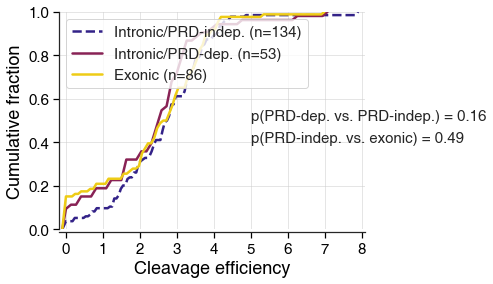

In [86]:
fig, ax = plt.subplots(1,1,figsize=(5.5, 4))

less_dep_intronic = \
KJ_joined[(KJ_joined["Exon_Intron"] == 'intronic') & (KJ_joined["P-rich dep"] == "Less dependent")]['Cleavage Efficiency'].dropna()
more_dep_intronic = \
KJ_joined[(KJ_joined["Exon_Intron"] == 'intronic') & (KJ_joined["P-rich dep"] == "More dependent")]['Cleavage Efficiency'].dropna()
exonic = KJ_joined[KJ_joined["Exon_Intron"] == 'exonic']['Cleavage Efficiency'].dropna()


### evaluate the histogram
less_dep_intronic_values, less_dep_intronic_base = np.histogram(less_dep_intronic, bins = len(less_dep_intronic))
more_dep_intronic_values, more_dep_intronic_base = np.histogram(more_dep_intronic, bins = len(more_dep_intronic))
exonic_values, exonic_base = np.histogram(exonic, bins = len(exonic))

### evaluate cumulative
less_dep_intronic_cumulative = np.cumsum(less_dep_intronic_values) / np.sum(less_dep_intronic_values)
more_dep_intronic_cumulative = np.cumsum(more_dep_intronic_values) / np.sum(more_dep_intronic_values)
exonic_cumulative = np.cumsum(exonic_values) / np.sum(exonic_values)

ax.plot(np.insert(less_dep_intronic_base[:-1], 0, less_dep_intronic_base[0]-0.1, axis = 0), \
        np.insert(less_dep_intronic_cumulative,0,0, axis=0), label='Intronic/PRD-indep. '+'(n='+str(len(less_dep_intronic))+")", \
        color = '#332288', linewidth=2.5, linestyle = '--')
ax.plot(np.insert(more_dep_intronic_base[:-1],0,more_dep_intronic_base[0]-0.1, axis=0),\
       np.insert(more_dep_intronic_cumulative,0,0,axis=0), label="Intronic/PRD-dep. " + "(n=" +str(len(more_dep_intronic))+")",\
       color='#882255', linewidth=2.5)
ax.plot(np.insert(exonic_base[:-1],0,exonic_base[0]-0.1, axis=0),\
       np.insert(exonic_cumulative,0,0,axis=0), label="Exonic " + "(n=" +str(len(exonic))+")",\
       color='#eecc16', linewidth=2.5)

ax.set_xlim(-0.2,8.1)
ax.set_ylim(0,1)
ax.set_xlabel("Cleavage efficiency", fontsize=18, color='black')
ax.set_ylabel("Cumulative fraction", fontsize=18, color='black')
ax.set_title("")
ax.legend(loc="upper left", fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
    
p0 = mannwhitneyu(less_dep_intronic, more_dep_intronic, alternative = 'two-sided')[1]
ax.text(5,0.5, 'p(PRD-dep. vs. PRD-indep.) = %.2f'%p0, fontsize=15)
p1 = mannwhitneyu(less_dep_intronic, exonic, alternative = 'two-sided')[1]
ax.text(5,0.4, 'p(PRD-indep. vs. exonic) = %.2f'%p1, fontsize=15)


fig.show()
#plt.savefig("Results/Figures/221102-Cleavage-Efficiency-HCT116.svg", bbox_inches='tight')

#### Cleavage Homogeneity

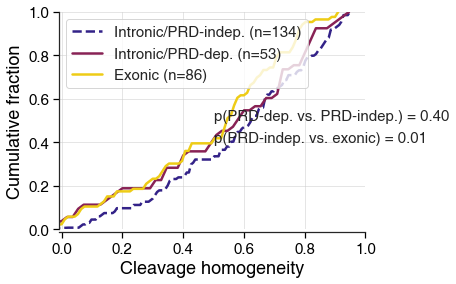

In [87]:
fig, ax = plt.subplots(1,1,figsize=(5.5, 4))

less_dep_intronic = \
KJ_joined[(KJ_joined["Exon_Intron"] == 'intronic') & (KJ_joined["P-rich dep"] == "Less dependent")]['Cleavage Homogeneity'].dropna()
more_dep_intronic = \
KJ_joined[(KJ_joined["Exon_Intron"] == 'intronic') & (KJ_joined["P-rich dep"] == "More dependent")]['Cleavage Homogeneity'].dropna()
exonic = KJ_joined[KJ_joined["Exon_Intron"] == 'exonic']['Cleavage Homogeneity'].dropna()


### evaluate the histogram
less_dep_intronic_values, less_dep_intronic_base = np.histogram(less_dep_intronic, bins = len(less_dep_intronic))
more_dep_intronic_values, more_dep_intronic_base = np.histogram(more_dep_intronic, bins = len(more_dep_intronic))
exonic_values, exonic_base = np.histogram(exonic, bins = len(exonic))

### evaluate cumulative
less_dep_intronic_cumulative = np.cumsum(less_dep_intronic_values) / np.sum(less_dep_intronic_values)
more_dep_intronic_cumulative = np.cumsum(more_dep_intronic_values) / np.sum(more_dep_intronic_values)
exonic_cumulative = np.cumsum(exonic_values) / np.sum(exonic_values)

ax.plot(np.insert(less_dep_intronic_base[:-1], 0, less_dep_intronic_base[0]-0.1, axis = 0), \
        np.insert(less_dep_intronic_cumulative,0,0, axis=0), label='Intronic/PRD-indep. '+'(n='+str(len(less_dep_intronic))+")", \
        color = '#332288', linewidth=2.5, linestyle = '--')
ax.plot(np.insert(more_dep_intronic_base[:-1],0,more_dep_intronic_base[0]-0.1, axis=0),\
       np.insert(more_dep_intronic_cumulative,0,0,axis=0), label="Intronic/PRD-dep. " + "(n=" +str(len(more_dep_intronic))+")",\
       color='#882255', linewidth=2.5)
ax.plot(np.insert(exonic_base[:-1],0,exonic_base[0]-0.1, axis=0),\
       np.insert(exonic_cumulative,0,0,axis=0), label="Exonic " + "(n=" +str(len(exonic))+")",\
       color='#eecc16', linewidth=2.5)

ax.set_xlim(-0.01,1)
ax.set_ylim(0,1)
ax.set_xlabel("Cleavage homogeneity", fontsize=18, color='black')
ax.set_ylabel("Cumulative fraction", fontsize=18, color='black')
ax.set_title("")
ax.legend(loc="upper left", fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
    
p0 = mannwhitneyu(less_dep_intronic, more_dep_intronic, alternative = 'two-sided')[1]
ax.text(0.5,0.5, 'p(PRD-dep. vs. PRD-indep.) = %.2f'%p0, fontsize=15)
p1 = mannwhitneyu(less_dep_intronic, exonic, alternative = 'two-sided')[1]
ax.text(0.5,0.4, 'p(PRD-indep. vs. exonic) = %.2f'%p1, fontsize=15)


fig.show()
#plt.savefig("Results/Figures/221102-Cleavage-Homogeneity-HCT116.svg", bbox_inches='tight')

#### Cleavage Efficiency & Homogeneity (Bot plot)

In [89]:
KJ_joined.head()

,baseMean,log2FoldChange,padj,pri-miRNA,Exon_Intron,P-rich dep,Chr,pri Start,pri End,phyloP_avg,Cleavage Efficiency,Cleavage Homogeneity
mature,,,,,,,,,,,,
hsa-let-7a-2-3p,52.394713,-0.901333,6.683580e-02,hsa-let-7a-2,intronic,Less dependent,chr11,122146521,122146593,6.635873,3.272476,0.787974
hsa-let-7b-3p,113.500150,-0.583679,7.642490e-02,hsa-let-7b,exonic,Less dependent,chr22,46113685,46113768,5.978929,3.022173,0.767644
hsa-let-7b-5p,3288.216511,-0.136267,6.918580e-01,hsa-let-7b,exonic,Less dependent,chr22,46113685,46113768,5.978929,3.022173,0.767644
hsa-let-7c-5p,86.709270,-0.235136,5.822707e-01,hsa-let-7c,intronic,Less dependent,chr21,16539827,16539911,7.165179,0.000000,0.119761
hsa-let-7d-3p,205.664358,-2.068898,4.782894e-14,hsa-let-7d,intronic,More dependent,chr9,94178833,94178920,5.244117,2.908662,0.492728


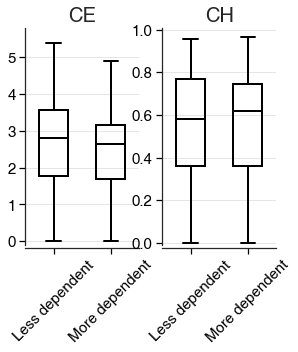

In [113]:
fig, ax = plt.subplots(1,2, figsize=(4.5,4))

### Cleavage Efficiency
ax_CE = sns.boxplot(x='P-rich dep', y = 'Cleavage Efficiency', data=KJ_joined, color='black', order=['Less dependent','More dependent'],\
                    boxprops={'facecolor': 'None'}, showfliers=False, ax=ax[0], width=0.5, fliersize=3.5, linewidth=2)

ax[0].set_ylim(-0.1,5.8)
ax[0].set_ylabel("", fontsize=18)
ax[0].set_xlabel("")
ax[0].set_title("CE", fontsize=20)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].grid(axis='y', alpha=0.5)
ax[0].spines['bottom'].set_position(('outward',3))

ax[0].tick_params(axis='x', colors='black')
ax[0].tick_params(axis='y', colors='black')

for label in ax[0].get_yticklabels():
    label.set_fontsize(15)
for label in ax[0].get_xticklabels():
    label.set_fontsize(15)
    label.set_rotation(45)

    
### Cleavage Homogeneity
ax_CH = sns.boxplot(x='P-rich dep', y = 'Cleavage Homogeneity', data=KJ_joined, color='black', order=['Less dependent','More dependent'],\
                    boxprops={'facecolor': 'None'}, showfliers=False, ax=ax[1], width=0.5, fliersize=3.5, linewidth=2)

ax[1].set_ylim(-0.01,1.01)
ax[1].set_ylabel("", fontsize=18)
ax[1].set_xlabel("")
ax[1].set_title("CH", fontsize=20)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].grid(axis='y', alpha=0.5)
ax[1].spines['bottom'].set_position(('outward',3))

ax[1].tick_params(axis='x', colors='black')
ax[1].tick_params(axis='y', colors='black')

for label in ax[1].get_yticklabels():
    label.set_fontsize(15)
for label in ax[1].get_xticklabels():
    label.set_fontsize(15)
    label.set_rotation(45)
    
#plt.savefig("Results/Figures/221102-CE-CH-box-HCT116.svg", bbox_inches='tight')

In [119]:
KJ_joined["P-rich dep"].value_counts()

Less dependent    217
More dependent     62
Name: P-rich dep, dtype: int64

In [117]:
len(only_MP)

1816

### phyloP with pre (from 5p end to 3p end = pre)

In [274]:
DD_analysis = pd.read_csv("210308_HCT116_DD_analysis.csv")[['mature', 'baseMean', 'log2FoldChange', 'padj', 'pri-miRNA', 'Exon_Intron']].set_index("mature")
DD_analysis.head()

,baseMean,log2FoldChange,padj,pri-miRNA,Exon_Intron
mature,,,,,
hsa-let-7a-2-3p,52.394713,-0.901333,6.683580e-02,hsa-let-7a-2,intronic
hsa-let-7b-3p,113.500150,-0.583679,7.642490e-02,hsa-let-7b,exonic
hsa-let-7b-5p,3288.216511,-0.136267,6.918580e-01,hsa-let-7b,exonic
hsa-let-7c-5p,86.709270,-0.235136,5.822707e-01,hsa-let-7c,intronic
hsa-let-7d-3p,205.664358,-2.068898,4.782894e-14,hsa-let-7d,intronic


In [275]:
log2FC_cutoff = 1.53452924346508

DD_analysis.loc[DD_analysis[(DD_analysis["padj"] < 0.05) & (DD_analysis["log2FoldChange"].abs() > log2FC_cutoff)].index, 'P-rich dep'] = "More dependent"
DD_analysis.loc[DD_analysis[(DD_analysis["padj"] >= 0.05) | (DD_analysis["log2FoldChange"].abs() <= log2FC_cutoff)].index, 'P-rich dep'] = "Less dependent"

DD_analysis.head()

,baseMean,log2FoldChange,padj,pri-miRNA,Exon_Intron,P-rich dep
mature,,,,,,
hsa-let-7a-2-3p,52.394713,-0.901333,6.683580e-02,hsa-let-7a-2,intronic,Less dependent
hsa-let-7b-3p,113.500150,-0.583679,7.642490e-02,hsa-let-7b,exonic,Less dependent
hsa-let-7b-5p,3288.216511,-0.136267,6.918580e-01,hsa-let-7b,exonic,Less dependent
hsa-let-7c-5p,86.709270,-0.235136,5.822707e-01,hsa-let-7c,intronic,Less dependent
hsa-let-7d-3p,205.664358,-2.068898,4.782894e-14,hsa-let-7d,intronic,More dependent


In [277]:
my_pri = set(DD_analysis["pri-miRNA"].dropna())

In [297]:
pre_coordinate = pd.read_table('200428_pre_annot_hg38_fromSC.txt')[['Chr','pre Start','pre End','strand','pri-miRNA']].set_index('pri-miRNA')
pre_coordinate = pre_coordinate.loc[my_pri]
print(pre_coordinate.shape)

(190, 4)


In [298]:
pre_coordinate.reset_index()[['Chr','pre Start', 'pre End']].to_csv('221102_pre_phyloP_input.tsv', sep='\t', header=None, index=False)

In [299]:
pre_phyloP = pd.read_table("221102_pre_phyloP100_output.bed", header=None).iloc[:,[0,1,4]]
pre_phyloP.rename(columns={0: "Chr", 1:"Coordinate", 4:"phyloP100"}, inplace=True)
pre_phyloP.head()

,Chr,Coordinate,phyloP100
0,chr1,1167878,1.882540
1,chr1,1167879,1.882540
2,chr1,1167880,2.777440
3,chr1,1167881,1.285940
4,chr1,1167882,0.589913


In [300]:
pre_coordinate['phyloP_avg'] = 0

for pre in pre_coordinate.index:
    pre_Start = pre_coordinate.loc[pre, 'pre Start']
    pre_End = pre_coordinate.loc[pre, 'pre End']
    pre_len = pre_End - pre_Start
    
    pre_chr = pre_coordinate.loc[pre, 'Chr']
    
    phyloP_sum = 0
    
    for i in range(pre_Start, pre_End):
        score = pre_phyloP[(pre_phyloP["Chr"] == pre_chr) & (pre_phyloP["Coordinate"] == i)]['phyloP100'].values
        phyloP_sum  = phyloP_sum + score
    phyloP_sum = np.mean(phyloP_sum)
    pre_coordinate.loc[pre, "phyloP_avg"] = phyloP_sum/pre_len 

In [301]:
pre_coordinate.head()

,Chr,pre Start,pre End,strand,phyloP_avg
pri-miRNA,,,,,
hsa-mir-1247,chr14,101560326,101560383,-,0.791198
hsa-mir-182,chr7,129770406,129770470,-,7.206708
hsa-mir-576,chr4,109488713,109488773,+,-0.105078
hsa-mir-449c,chr5,55172275,55172337,-,1.922021
hsa-mir-361,chrX,85903641,85903702,-,2.504297


In [307]:
pre_phyloP_joined = DD_analysis.join(pre_coordinate, on='pri-miRNA')
pre_phyloP_joined.tail()

,baseMean,log2FoldChange,padj,pri-miRNA,Exon_Intron,P-rich dep,Chr,pre Start,pre End,strand,phyloP_avg
mature,,,,,,,,,,,
hsa-miR-96-5p,375.213714,-0.072018,9.006381e-01,hsa-mir-96,exonic,Less dependent,chr7,129774697,129774761,-,6.811382
hsa-miR-98-3p,50.967285,-1.553478,1.778344e-03,hsa-mir-98,intronic,More dependent,chrX,53556241,53556320,-,4.990853
hsa-miR-98-5p,1003.927607,-1.260535,3.461109e-04,hsa-mir-98,intronic,Less dependent,chrX,53556241,53556320,-,4.990853
hsa-miR-99b-3p,94.634426,-1.795472,2.056602e-06,hsa-mir-99b,intronic,More dependent,chr19,51692618,51692677,+,2.307230
hsa-miR-99b-5p,947.857727,-1.829807,1.599476e-10,hsa-mir-99b,intronic,More dependent,chr19,51692618,51692677,+,2.307230


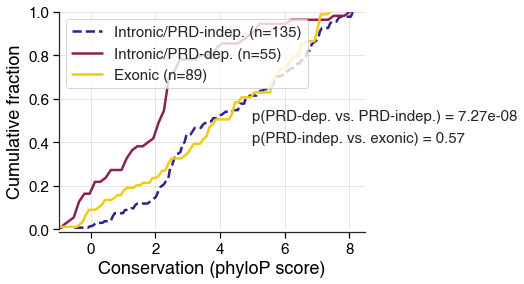

In [308]:
fig, ax = plt.subplots(1,1,figsize=(5.5, 4))


less_dep_intronic = \
pre_phyloP_joined[(pre_phyloP_joined["Exon_Intron"] == 'intronic') & (pre_phyloP_joined["P-rich dep"] == "Less dependent")]['phyloP_avg'].dropna()
more_dep_intronic = \
pre_phyloP_joined[(pre_phyloP_joined["Exon_Intron"] == 'intronic') & (pre_phyloP_joined["P-rich dep"] == "More dependent")]['phyloP_avg'].dropna()
exonic = pre_phyloP_joined[pre_phyloP_joined["Exon_Intron"] == 'exonic']['phyloP_avg'].dropna()


### evaluate the histogram
less_dep_intronic_values, less_dep_intronic_base = np.histogram(less_dep_intronic, bins = len(less_dep_intronic))
more_dep_intronic_values, more_dep_intronic_base = np.histogram(more_dep_intronic, bins = len(more_dep_intronic))
exonic_values, exonic_base = np.histogram(exonic, bins = len(exonic))

### evaluate cumulative
less_dep_intronic_cumulative = np.cumsum(less_dep_intronic_values) / np.sum(less_dep_intronic_values)
more_dep_intronic_cumulative = np.cumsum(more_dep_intronic_values) / np.sum(more_dep_intronic_values)
exonic_cumulative = np.cumsum(exonic_values) / np.sum(exonic_values)

ax.plot(np.insert(less_dep_intronic_base[:-1], 0, less_dep_intronic_base[0]-0.1, axis = 0), \
        np.insert(less_dep_intronic_cumulative,0,0, axis=0), label='Intronic/PRD-indep. '+'(n='+str(len(less_dep_intronic))+")", \
        color = '#332288', linewidth=2.5, linestyle = '--')
ax.plot(np.insert(more_dep_intronic_base[:-1],0,more_dep_intronic_base[0]-0.1, axis=0),\
       np.insert(more_dep_intronic_cumulative,0,0,axis=0), label="Intronic/PRD-dep. " + "(n=" +str(len(more_dep_intronic))+")",\
       color='#882255', linewidth=2.5)
ax.plot(np.insert(exonic_base[:-1],0,exonic_base[0]-0.1, axis=0),\
       np.insert(exonic_cumulative,0,0,axis=0), label="Exonic " + "(n=" +str(len(exonic))+")",\
       color='#eecc16', linewidth=2.5)

ax.set_xlim(-1,8.5)
ax.set_ylim(0,1)
ax.set_xlabel("Conservation (phyloP score)", fontsize=18, color='black')
ax.set_ylabel("Cumulative fraction", fontsize=18, color='black')
ax.set_title("")
ax.legend(loc="upper left", fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
    
p0 = mannwhitneyu(less_dep_intronic, more_dep_intronic, alternative = 'two-sided')[1]
ax.text(5,0.5, 'p(PRD-dep. vs. PRD-indep.) = %.2e'%p0, fontsize=15)
p1 = mannwhitneyu(less_dep_intronic, exonic, alternative = 'two-sided')[1]
ax.text(5,0.4, 'p(PRD-indep. vs. exonic) = %.2f'%p1, fontsize=15)


fig.show()

#plt.savefig("Results/Figures/221102-phyloP-pre-HCT116.svg", bbox_inches='tight')